<a href="https://colab.research.google.com/github/NicoleMeinie/Zindi_Regression/blob/master/Zindi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Import data

In [0]:
Test = pd.read_csv('Test.csv')
Train = pd.read_csv('Train.csv')
#Riders = pd.read_csv('Riders.csv')
#SampleSubmission = pd.read_csv('SampleSubmission.csv')
#VariableDefinitions = pd.read_csv('VariableDefinitions.csv')

#Exploratory Data Analysis

In [3]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

Observations:

*   The 'Time' columns are stored as object datatypes instead of date_time
*   The 'Temperature' and 'Percipitation' columns contain Null values
*   There are a few ID columns that can be dropped for the purpose of training the models
* The 'Vehicle Type' column can be dropped since all the entries are 'Bike'
* The 'Personal or Business' column only contains the strings 'personal'and 'business' this will have to be encoded before the data can be used to train the models 






In [4]:
Train.describe().T

,count,mean,std,min,25%,50%,75%,max
Platform Type,21201.0,2.752182,0.625178,1.000000,3.000000,3.000000,3.000000,4.000000
Placement - Day of Month,21201.0,15.653696,8.798916,1.000000,8.000000,15.000000,23.000000,31.000000
Placement - Weekday (Mo = 1),21201.0,3.240083,1.567295,1.000000,2.000000,3.000000,5.000000,7.000000
Confirmation - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Confirmation - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Arrival at Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Destination - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000


Observations:

*   The 'Platform Type' column only contains the numbers 1 - 4, which corresponds to the different platforms customers can use to place their orders.
*   The average distance travelled to deliver an order is 9.5km with a std of 5.7km.
* The arverage Temperature at the time of delivery is 23 degrees celcius with a std of 3.2.



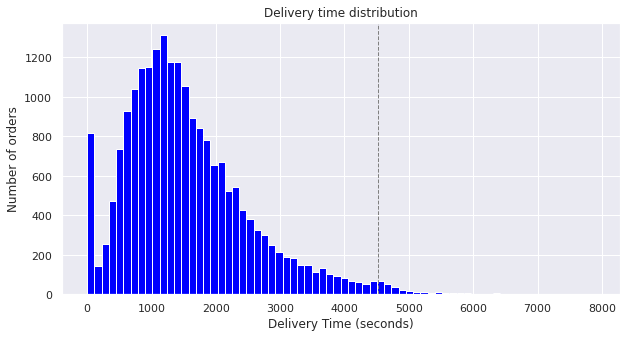

In [20]:
# Plotting a histogram of delivery times and outlier threshold

mu = Train.iloc[:,28].mean()
sd = Train.iloc[:,28].std()
li = mu + 3*sd

sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.hist(Train.iloc[:,28], bins = 70, color = 'blue')
_ = plt.title('Delivery time distribution')
_ = plt.xlabel('Delivery Time (seconds)')
_ = plt.ylabel('Number of orders')
_ = plt.axvline(li, color = 'gray', linestyle = 'dashed', linewidth = 1)
plt.show()

Observations: 

From the histogram plot above it’s clear that the delivery times are skewed, with the majority of orders being delivered in about 16 minutes 

The grey dotted line above indicates the threshold for existance of outliers (measured by the presence of values 3 standard deviation away from the mean.)

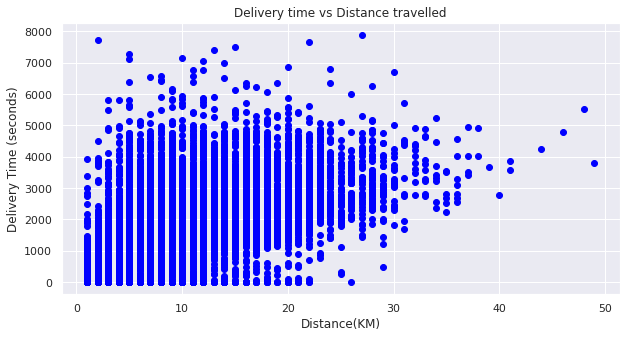

In [6]:
# Plotting the relationship between the delivery time and distance travelled

sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.scatter(Train.iloc[:,20],Train.iloc[:,28], color = 'blue')
_ = plt.title('Delivery time vs Distance travelled')
_ = plt.xlabel('Distance(KM)')
_ = plt.ylabel('Delivery Time (seconds)')
plt.show()

Observations:

The relationship looks like it could be linear, although it is hard to tell from this graph alone


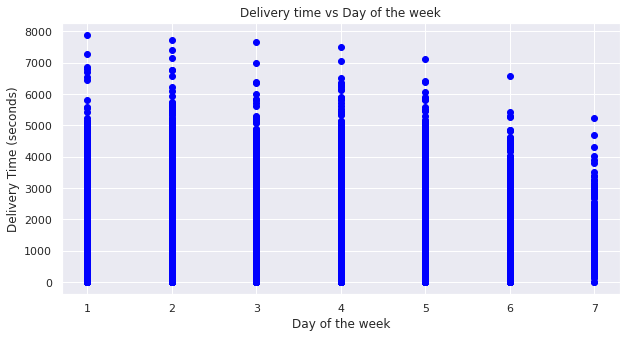

In [19]:
# Exploring the relationship between the day of week that arders are placed and the delivery times 

sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.scatter(Train.iloc[:,12],Train.iloc[:,28], color = 'blue')
_ = plt.title('Delivery time vs Day of the week')
_ = plt.xlabel('Day of the week')
_ = plt.ylabel('Delivery Time (seconds)')
plt.show()


Observations:

Deliveries are generally faster over the weekend, with the fastest delivery times on Sundays

# Checking for Multicolinearity

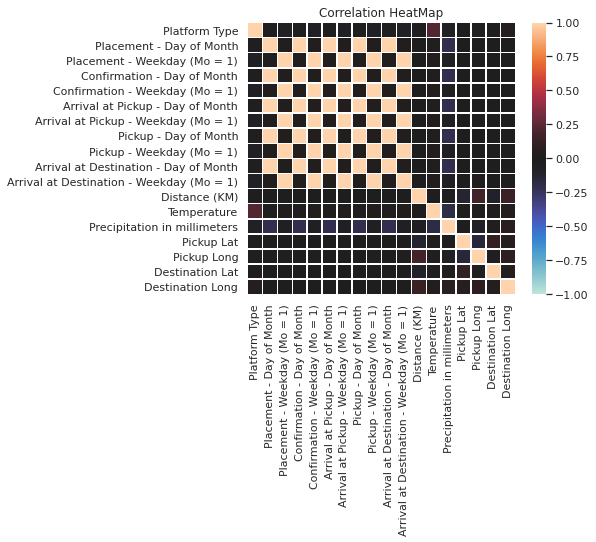

In [7]:
features = Train.iloc[:,:-1]
targets = Train.iloc[:,-1]

#creating pairwise correlation of columns using Pearson's R,
corr = features.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

# Converting data types and dealing with missing values

In [8]:
# converting object data types to date_time 
Train['Placement - Time'] = pd.to_datetime(Train['Placement - Time'])
Train['Confirmation - Time'] = pd.to_datetime(Train['Confirmation - Time'])
Train['Arrival at Pickup - Time'] = pd.to_datetime(Train['Arrival at Pickup - Time'])
Train['Pickup - Time'] = pd.to_datetime(Train['Pickup - Time'])
Train['Arrival at Destination - Time'] = pd.to_datetime(Train['Arrival at Destination - Time'])

# Replacing Null values in the temperature column with the average value 
from sklearn.impute import SimpleImputer
imputer_temp = SimpleImputer(missing_values = np.NaN, strategy = 'mean')
imputer_temp.fit(Train.iloc[:,20:22])
Train.iloc[:,20:22] = imputer_temp.transform(Train.iloc[:,20:22])

# Replacing the Null values in the precipitation column with 0
imputer_prec = SimpleImputer(missing_values = np.NaN, strategy = 'constant', fill_value = 0)
imputer_prec.fit(Train.iloc[:,22:])
Train.iloc[:,22:] = imputer_prec.transform(Train.iloc[:,22:])         

# Drop Vehcle type column since we are only dealing with bikes 
# Train.drop('Vehicle Type', axis=1, inplace=True)
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Order No                                   21201 non-null  object        
 1   User Id                                    21201 non-null  object        
 2   Vehicle Type                               21201 non-null  object        
 3   Platform Type                              21201 non-null  int64         
 4   Personal or Business                       21201 non-null  object        
 5   Placement - Day of Month                   21201 non-null  int64         
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64         
 7   Placement - Time                           21201 non-null  datetime64[ns]
 8   Confirmation - Day of Month                21201 non-null  int64         
 9   Confirmation - We

# Encode Categorical data
The 'business or personal' column needs to be converted to 1's and 0's

> Business = 1

> Personal = 0



In [0]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer

#ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [4])], remainder = 'passthrough')
#Train = np.array(ct.fit_transform(Train))

# Building the different models

* Multiple linear regression
* polynomial regression 
* Decision Tree Regression
* Random Forest Regression





In [10]:
# Thinning the train data set - only want the variables that actually have an effect on the delivery time 
Train_lin = Train.iloc[:,20:]
Train_lin.drop('Rider Id', axis=1, inplace=True)
Train_lin.drop('Pickup Long', axis=1, inplace=True)
Train_lin.drop('Pickup Lat', axis=1, inplace=True)
Train_lin.drop('Destination Lat', axis=1, inplace=True)
Train_lin.drop('Destination Long', axis=1, inplace=True)
Train_lin.info()
X = Train_lin.iloc[:,:-1]
y = Train_lin.iloc[:,-1]

# splitting the data in a test and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Building a linear regression model 
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

# Building a decision tree regression model 
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Building a random forest regression model 
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 25)
forest.fit(X_test, y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Distance (KM)                 21201 non-null  float64
 1   Temperature                   21201 non-null  float64
 2   Precipitation in millimeters  21201 non-null  float64
 3   Time from Pickup to Arrival   21201 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 662.7 KB


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#Calculating RMSE

In [16]:
from sklearn.metrics import mean_squared_error

# Multiple linear regression
y_pred_test = lm.predict(X_test)
y_pred_train = lm.predict(X_train)
rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)

# Decision Tree regression
y_pred_test_tree = tree.predict(X_test)
y_pred_train_tree = tree.predict(X_train)
rmse_test_tree = round(np.sqrt(mean_squared_error(y_test, y_pred_test_tree)),2)
rmse_train_tree = round(np.sqrt(mean_squared_error(y_train, y_pred_train_tree)),2)

# Random forrest regression 
y_pred_test_forest = forest.predict(X_test)
y_pred_train_forest = forest.predict(X_train)
rmse_test_forest = round(np.sqrt(mean_squared_error(y_test, y_pred_test_forest)),2)
rmse_train_forest = round(np.sqrt(mean_squared_error(y_train, y_pred_train_forest)),2)

data = {'Regression model':  ['Mulitiple linear', 'Decision Tree', 'Random Forest'],
        'RMSE Training': [rmse_train, rmse_train_tree, rmse_train_forest],
        'RMSE Testing' : [rmse_test, rmse_test_tree, rmse_test_forest]
        }

df = pd.DataFrame (data, columns = ['Regression model', 'RMSE Training', 'RMSE Testing'])
print(df)


   Regression model  RMSE Training  RMSE Testing
0  Mulitiple linear         804.47        800.98
1     Decision Tree         701.98        898.14
2     Random Forest         906.07        618.20
